# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

#**CIFAR10**




In [26]:
from __future__ import print_function
import argparse
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

#Batch preprocessing

In [32]:
batch_size = 100
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_dataset = datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

test_dataset = datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/cifar-10-python.tar.gz to ../data


#Network classes

In [ ]:
class Net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1,padding=1)
        self.act1=nn.ReLU()
        self.conv2 = nn.Conv2d(6, 12, 3, 1,padding=1)
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        #Flatten in forward function
        self.fc1 = nn.Linear(16*16*12, 100)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(100, 10)
        #self.act3 = nn.Softmax(dim=1)

    def forward(self, x):
        #torch.Size([batch_size, 3, 32, 32])
        x = self.conv1(x)
        #torch.Size([batch_size, 30, 32, 32])
        x = self.act1(x)
        x = self.conv2(x)
        #torch.Size([batch_size,60,32,32])
        x = self.max_pool2(x)
        #torch.Size([batch_size, 60, 16, 16])
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        #torch.Size([batch_size, 15360])
        x = self.fc1(x)
        #torch.Size([batch_size, 100])
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([batch_size, 10])
        x = F.log_softmax(x,dim=1)
        return x
    
    #Using Softmax only for probability predictions
    #In training we don't really need Softmax, faster not to use it
    def inference(self,x):
        x = self.forward(x)
        x = self.act3(x)
        return x








class Le_net(nn.Module):
    def __init__(self):
        super(Le_net, self).__init__()

        #in 3*32*32
        self.conv1 = nn.Conv2d(3, 3, 3)
        self.conv2 = nn.Conv2d(3,6,3)
        self.act1=nn.ReLU()
        self.max_pool1=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.act2 = nn.ReLU()
        #out 6*14*14

        #in 6*14*14
        self.conv3 = nn.Conv2d(6, 6, 3)
        self.conv4 = nn.Conv2d(6, 16, 3)
        self.act3 = nn.ReLU()
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)
        self.act4 = nn.ReLU()
        #out 16*5*5

        #Flatten in forward function
        self.fc1 = nn.Linear(16*5*5, 100)
        self.act5 = nn.ReLU()
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(100, 10)
        #last activation in forward function

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.act1(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.act3(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.act4(x)

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.act5(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x

#Training procedure

In [2]:
def train(model, train_dataset, epochs, optimizer):
    model.train()
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_dataset:
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()   # zero the gradient buffers
            output = model.forward(data)
            
            loss = F.nll_loss(output, target)
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

#Test procedure

In [3]:
def test(model, device, test_loader):
    model.eval()
    loss=0
    accuracy = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            loss+= F.nll_loss(output,target)
            pred = output.argmax(dim=1, keepdim=True)
            target = target.view_as(pred)
            for i,single_pred in enumerate(pred):
                if single_pred == target[i]:
                    correct+= 1
            total += len(pred)
    loss = loss/len(test_loader)
    accuracy = correct / total
    
    print('Loss: ',loss.data.item())
    print('\n Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, total, 100. * accuracy))

#New neral network from class
####you can restart to refresh weights to random

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")
net = Le_net().to(device)

#Main loop

######Try your luck!

Epoch        0 Loss: 2.023052774190903
Epoch        1 Loss: 1.8418250098228455
Epoch        2 Loss: 1.7726847343444825
Epoch        3 Loss: 1.7335421686172485
Epoch        4 Loss: 1.708513421535492
Epoch        5 Loss: 1.6845438144207001
Epoch        6 Loss: 1.6667478368282318
Epoch        7 Loss: 1.652770173549652
Epoch        8 Loss: 1.6375824866294861
Epoch        9 Loss: 1.6206058115959168


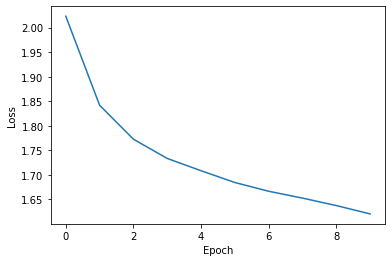

tensor(1.4271, device='cuda:0')

 Accuracy: 4893/10000 (49%)

Epoch        0 Loss: 1.6141264753341675
Epoch        1 Loss: 1.599934963941574
Epoch        2 Loss: 1.593935870885849
Epoch        3 Loss: 1.5871552679538727
Epoch        4 Loss: 1.5834620566368103
Epoch        5 Loss: 1.5701629309654235
Epoch        6 Loss: 1.5674185421466826
Epoch        7 Loss: 1.5552667605876922
Epoch        8 Loss: 1.5509660532474518
Epoch        9 Loss: 1.5531673192977906


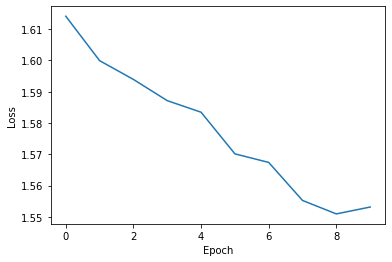

tensor(1.3652, device='cuda:0')

 Accuracy: 5216/10000 (52%)

Epoch        0 Loss: 1.5444414491653442
Epoch        1 Loss: 1.5458014476299287
Epoch        2 Loss: 1.5413145153522492
Epoch        3 Loss: 1.5364360620975495
Epoch        4 Loss: 1.5317096791267395
Epoch        5 Loss: 1.5304151721000672
Epoch        6 Loss: 1.5288884253501893
Epoch        7 Loss: 1.5323091044425965
Epoch        8 Loss: 1.5157515091896057
Epoch        9 Loss: 1.5210596220493318


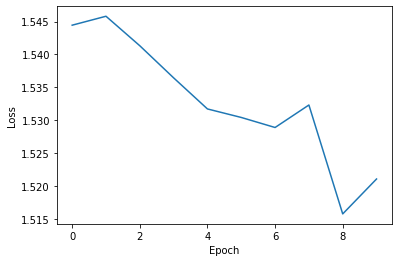

tensor(1.3118, device='cuda:0')

 Accuracy: 5380/10000 (54%)



In [ ]:
#Main loop train epochs_train times and test once and
#repeat it train_cycles times
train_cycles=3
epochs_train=10
lr=0.001
#Main loop
for i in range(train_cycles):
    train(model=net, train_dataset=train_loader, epochs=epochs_train, optimizer=optim.Adam(net.parameters(), lr=lr))
    test(model=net,device=device,test_loader=test_loader)

#Saving trained model

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#Loading saved model from file 

In [ ]:
print('New model copy with random weight:\n')
net = Le_net().to(device)
test(model=net,device=device,test_loader=test_loader)


print('\n\n\n Load our model from file gives:\n')
net.load_state_dict(torch.load(PATH))
test(model=net,device=device,test_loader=test_loader)

New model copy with random weight:

Loss:  2.3043265342712402

 Accuracy: 870/10000 (9%)




 Load our model from file gives:

Loss:  1.3117802143096924

 Accuracy: 5380/10000 (54%)





---



#**MNIST**

In [1]:
from __future__ import print_function
import argparse
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
batch_size = 100
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

test_dataset = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, **kwargs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class MNIST_net(nn.Module):
    def __init__(self):
        super(MNIST_net, self).__init__()

        #in 3*28*28
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3,6,3)
        self.act1=nn.ReLU()
        self.max_pool1=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.act2 = nn.ReLU()
        #out 6*12*12

        #in 6*12*12
        self.conv3 = nn.Conv2d(6, 6, 3)
        self.conv4 = nn.Conv2d(6, 16, 3)
        self.act3 = nn.ReLU()
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)
        self.act4 = nn.ReLU()
        #out 16*4*4

        #Flatten in forward function
        self.fc1 = nn.Linear(16*4*4, 100)
        self.act5 = nn.ReLU()
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(100, 10)
        #last activation in forward function

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.act1(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.act3(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.act4(x)

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.act5(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x

In [4]:
def train(model, train_dataset, epochs, optimizer):
    model.train()
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_dataset:
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()   # zero the gradient buffers
            output = model.forward(data)
            
            loss = F.nll_loss(output, target)
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

In [5]:
def test(model, device, test_loader):
    model.eval()
    loss=0
    accuracy = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            loss+= F.nll_loss(output,target)
            pred = output.argmax(dim=1, keepdim=True)
            target = target.view_as(pred)
            for i,single_pred in enumerate(pred):
                if single_pred == target[i]:
                    correct+= 1
            total += len(pred)
    loss = loss/len(test_loader)
    accuracy = correct / total
    
    print('Loss: ',loss.data.item())
    print('\n Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, total, 100. * accuracy))

In [6]:
device = torch.device("cuda" if use_cuda else "cpu")
net = MNIST_net().to(device)

Epoch        0 Loss: 0.5359303905318181
Epoch        1 Loss: 0.2242167779803276
Epoch        2 Loss: 0.17830282667651773
Epoch        3 Loss: 0.15707516232815882
Epoch        4 Loss: 0.14797141894077262
Epoch        5 Loss: 0.13910048555893204
Epoch        6 Loss: 0.129666211597311
Epoch        7 Loss: 0.12490046924290557
Epoch        8 Loss: 0.12346991261777779
Epoch        9 Loss: 0.11735283345604937


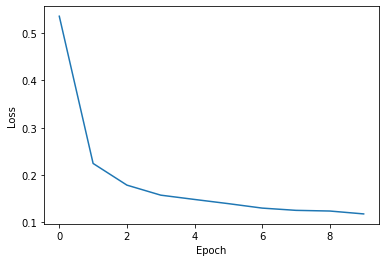

Loss:  0.04296719282865524

 Accuracy: 9861/10000 (99%)



In [7]:
#Main loop train epochs_train times and test once and
#repeat it train_cycles times
train_cycles=1
epochs_train=10
lr=0.001
#Main loop
for i in range(train_cycles):
    train(model=net, train_dataset=train_loader, epochs=epochs_train, optimizer=optim.Adam(net.parameters(), lr=lr))
    test(model=net,device=device,test_loader=test_loader)

In [8]:
from google.colab import drive
drive.mount('/content/drive',force_remount= True)

Mounted at /content/drive


In [9]:
path = '/content/drive/MyDrive/Colab_Notebooks/minst_net.pth'
torch.save(net.state_dict(), path)

0
9
1
2
3
4
5
6
7
8


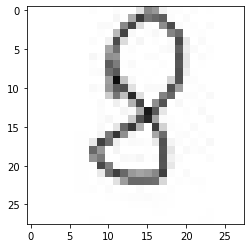

In [10]:
import cv2
import matplotlib.pyplot as plt
import glob

path = '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST'
image_names = glob.glob(path+'/*.jpg')

for image_name in image_names:
    image = cv2.imread(image_name)
    print(image_name[-5:-4])
    plt.imshow(image)



In [29]:
import torch
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self, image_names, transform = None):
        self.samples = image_names
        print(self.samples)
        if transform is None:
            self.should_transform = False
        else:
            self.transform = transform
            self.should_transform = True

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        img = cv2.imread(self.samples[idx])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.GaussianBlur(img, (3, 3), 0)
        name = self.samples[idx][-5:-4]
        if self.should_transform:
            img_transformed = self.transform(img)
        else:
            img_transformed = img
        return img_transformed, int(name)

In [49]:
my_dataset = ImgDataset(image_names=image_names,transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((1.2,), (0.3081,))
                    ]))

['/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/0.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/9.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/1.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/2.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/3.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/4.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/5.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/6.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/7.jpg', '/content/drive/MyDrive/Colab_Notebooks/datasets/nums_for_MNIST/8.jpg']


tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

ValueError: ignored

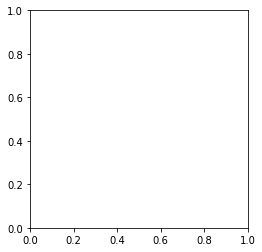

In [52]:
print(train_dataset[0][0])
print(my_dataset[0][0])

In [50]:


my_data_loader = torch.utils.data.DataLoader(my_dataset, batch_size=1, shuffle=True)
test(model=net,device=device,test_loader=my_data_loader)

Loss:  2.2120742797851562

 Accuracy: 1/10 (10%)

